<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [46]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving dali-image.jpg to dali-image (18).jpg

Upload Style Image


Saving starry night.jpg to starry night (11).jpg
Content Path: <_io.BytesIO object at 0x7fe54f2ba830>
Style Path: <_io.BytesIO object at 0x7fe54f2bac50>


In [47]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


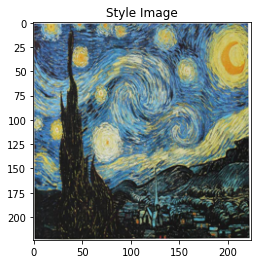

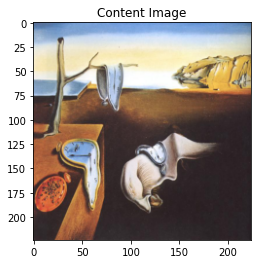

In [48]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [49]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [50]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer

# Style
content_requested = [vgg_names.index('conv4_2')]
style_requested = [vgg_names.index('conv1_1'), vgg_names.index('conv2_1'), 
                   vgg_names.index('conv3_1'), vgg_names.index('conv4_1'), 
                   vgg_names.index('conv5_1')]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
vgg_content = VGGIntermediate(requested=content_requested).cuda()
vgg_style = VGGIntermediate(requested=style_requested).cuda()

# Cache the outputs of the content and style layers for their respective images
content_out = vgg_content(content_image)

style_out = vgg_style(style_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [51]:
def gram_matrix(input):
  b,c,h,w = input.shape
  input.squeeze(0)
  input = torch.reshape(input, (c, h*w))
  gram = torch.matmul(input, torch.transpose(input, 0, 1))
  return gram
  
class ContentLoss(nn.Module):
  def __init__(self, P_l):
    super(ContentLoss, self).__init__()
    self.P_l = list(P_l.values())[0].detach()
  
  def forward(self, F_l):
    F_l = list(F_l.values())[0]
    return 0.5 * F.mse_loss(F_l, self.P_l)
    
class StyleLoss(nn.Module):
  def __init__(self, orig_image_style_layers):
    super(StyleLoss, self).__init__()
    self.grams = []
    for key in orig_image_style_layers.keys():
      F_l = orig_image_style_layers[key].detach()
      self.grams.append(gram_matrix(F_l))
  
  def forward(self, gen_image_style_layers):  # N_l is the number of features (channels), M_l is the size of each feature (height times width of feature map)
    loss = 0
    for l, key in enumerate(gen_image_style_layers.keys()):
      G_l = gram_matrix(gen_image_style_layers[key])
      F_l = self.grams[l]
      N_l = gen_image_style_layers[key].shape[1]
      M_l = gen_image_style_layers[key].shape[2] * gen_image_style_layers[key].shape[3]
      mse = F.mse_loss(G_l, F_l) / len(gen_image_style_layers)
      E_l = mse / (4 * N_l**2 * M_l**2)
      loss += E_l / 5
    return loss

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
content_objective = ContentLoss(content_out)

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
style_objective = StyleLoss(style_out)

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



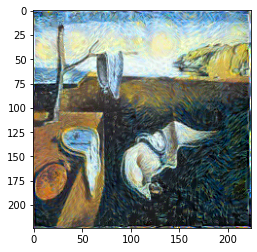

In [65]:
# Start with a copy of the content image
gen_image = nn.Parameter(content_image.clone())

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
optimizer = optim.Adam([gen_image], lr=0.0008)
num_epochs = 5000
alpha = 1
beta = 1.5e7
loop_rate = 1
loop = tqdm(total=num_epochs / loop_rate, position=0, leave=False)

losses = []

for epoch in range(num_epochs):
  gc.collect()
  optimizer.zero_grad()

  content_loss = content_objective(vgg_content(gen_image)) * alpha
  style_loss = style_objective(vgg_style(gen_image)) * beta
  total_loss = content_loss + style_loss

  if epoch % loop_rate == 0:
    loop.set_description("epoch: %0.0f, content_loss: %0.3f, style_loss: %0.3f, total_loss: %0.3f" % (epoch, content_loss, style_loss, total_loss))
    loop.update(1)
    losses.append((content_loss.item(), style_loss.item(), total_loss.item()))

  total_loss.backward(retain_graph=True)
  optimizer.step()
  gen_image.data.clamp_(0,1) # normalize image
  del content_loss, style_loss, total_loss

loop.close()

# Show the image
display(gen_image)

In [1]:
cl, sl, tl = zip(*losses)

plt.plot(cl)
plt.title("Content Loss")
plt.show()
plt.plot(sl)
plt.title("Style Loss")
plt.show()
plt.plot(tl)
plt.title("Total Loss")
plt.show()

NameError: ignored

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$\mathcal{L}_{content} (\vec{p},\vec{x},l) = \frac{1}{2} \sum_{i,j} (F_{ij}^l - P_{ij}^l)^2$

$\vec{p}$ and $\vec{x}$ are the original image and the generated image, respectively.

$l$ is a layer of the VGG network.

$F^l$ is the feature representation output of the generated image in layer $l$.

$P^l$ is the feature representation of the original image in layer $l$.

In plain english, this equation takes the MSE of the predictions (generated image feature representation matrix $F$ at layer $l$) and the actuals (original image feature representation $P$ at layer $l$).

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$G_{ij}^l = \sum_k F_{ik}^l F_{jk}^l$

$G_{ij}^l$ is the gram matrix of an image feature representation at layer $l$. The gram matrix is an inner product of the vectors of a matrix.

$F^l$ is the feature representation of an image at layer $l$.

In plain english, this equation takes the inner product of each of the vectors in the feature representation $F^l$ to show how the features are correlated with each other.

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{i,j} (G_{ij}^l - A_{ij}^l)^2$

$E_l$ is the contribution of style loss in one layer of the network.

$N_l$ is the number of feature maps in the output of the network layer $l$. In other words, it is the number of output channels in layer $l$.

$M_l$ is the size of each feature map in layer $l$, which is the height times the width of each feature map.

$G^l$ is the gram matrix of the generated image feature representation in layer $l$.

$A^l$ is the gram matrix of the original image feature representation in layer $l$.

In plain english, this equation computes the contribution to style loss of one layer in the set of style features layers by finding the MSE of the generated image feature representation gram matrix at layer $l$ and the original image feature representation gram matrix at layer $l$ divided by 4 times the number of feature maps squared times the size of each feature map squared.

- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$\mathcal{L}_{style} (\vec{a}, \vec{x}) = \sum_{l=0}^L w_l E_l$

$\vec{a}$ is the artwork image.

$\vec{x}$ is the generated image.

$w_l$ is a weight factor given to each layer's style loss. In other words, how much should this layer loss contribute to the total loss.

In plain english, for each of the style losses in the set of style layers, we add up their individual contributions to find the total style loss.

**DONE:**